# Aging Game Walkthrough

This notebook demonstrates the **Aging Game** - a communication game where two agents learn to communicate by alternating between sender and receiver roles.

## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

import egg.core as core
from egg.zoo.aging.archs import FullAgent, AlternatingGame
from egg.zoo.aging.features import VectorsLoader

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# GPU configuration
GPU_NUM = 1

if torch.cuda.is_available():
    torch.cuda.set_device(GPU_NUM)
    torch.cuda.manual_seed(42)
    device = torch.device(f'cuda:{GPU_NUM}')
else:
    device = torch.device('cpu')
    print("CUDA not available, using CPU")

print(f"Device: {device}")

/local/s3965392/conda_envs/egg39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/local/s3965392/conda_envs/egg39/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/local/s3965392/conda_envs/egg39/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attr

Device: cuda:1


## 2. The Dataset - What Are Agents Communicating About?

In a **referential game**, one agent (the sender) sees a **target object** and must describe it to another agent (the receiver) who sees the target mixed with **distractor objects**. The receiver must identify which object is the target.

Let's create a simple dataset and look at what the data looks like.

In [3]:
# Create data loader with simple parameters
data_loader = VectorsLoader(
    perceptual_dimensions=[3, 3, 3],    # 3 features, each with 3 possible values
    n_distractors=3,                    # Receiver sees target + 2 distractors (3 total)
    batch_size=32,
    train_samples=1024,
    validation_samples=128,
    test_samples=128,                   # 128/32 = 4 batches (2 A→B, 2 B→A)
    shuffle_train_data=True,
    seed=42
)

train_loader, val_loader, test_loader = data_loader.get_iterators()

print(f"Number of features: {data_loader.n_features}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batches per direction: {len(test_loader)//2}")

Number of features: 3
Train batches: 32
Validation batches: 4
Test batches: 4
Batches per direction: 2


### Let's look at one batch of data

Each training example consists of:
- **sender_input**: The target features (what the sender sees)
- **receiver_input**: All candidates (target + distractors, what the receiver sees)
- **labels**: Which position (0, 1, or 2) contains the target

In [4]:
# Get one batch
sample_batch = next(iter(train_loader))
sender_input, labels, receiver_input = sample_batch

# Display the shapes
print(f"Batch shapes:")
print(f"sender_input: {sender_input.shape}          # (batch_size, n_features)")
print(f"receiver_input: {receiver_input.shape}          # (batch_size, n_distractors+1, n_features)")
print(f"labels: {labels.shape}          # (batch_size,)")

# Display some examples
print(f"\nExample:")
print(f"\nTarget (what sender sees):")
print(f"    {sender_input[0].numpy()}")
print(f"\nCandidates (what receiver sees):")
for i in range(4):
    marker = " <- TARGET" if labels[0].item() == i else ""
    print(f"    [{i}] {receiver_input[0, i].numpy()}{marker}")
print(f"\nThe receiver must pick candidate {labels[0].item()} based on the sender's message")

Batch shapes:
sender_input: torch.Size([32, 3])          # (batch_size, n_features)
receiver_input: torch.Size([32, 4, 3])          # (batch_size, n_distractors+1, n_features)
labels: torch.Size([32])          # (batch_size,)

Example:

Target (what sender sees):
    [2. 1. 3.]

Candidates (what receiver sees):
    [0] [3. 3. 1.]
    [1] [3. 3. 2.]
    [2] [2. 1. 2.]
    [3] [2. 1. 3.] <- TARGET

The receiver must pick candidate 3 based on the sender's message


## 3. Agent Architecture - Building Bidirectional Agents

Unlike traditional games with separate sender and receiver, our agents are **bidirectional** - they can both send and receive messages. Each `FullAgent` contains:

- **feature_encoder**: Processes input features (the agent's "perception")
- **sender_module**: Encodes targets for message generation
- **receiver_module**: Compares messages with candidates

Importantly, **Agent A and Agent B have separate encoders**, making them **heterogeneous** - they perceive the world differently!

In [5]:
# Create two agents
agent_A = FullAgent(
    n_features=data_loader.n_features,
    feature_hidden=32,
    sender_hidden=32,
    receiver_hidden=32
)

agent_B = FullAgent(
    n_features=data_loader.n_features,
    feature_hidden=32,
    sender_hidden=32,
    receiver_hidden=32
)

print("Agent A architecture:")
print(agent_A)
print(f"\nAgent A parameters: {sum(p.numel() for p in agent_A.parameters()):,}")
print(f"Agent B parameters: {sum(p.numel() for p in agent_B.parameters()):,}")

Agent A architecture:
FullAgent(
  (feature_encoder): FeatureEncoder(
    (fc): Linear(in_features=3, out_features=32, bias=True)
  )
  (sender_module): Sender(
    (feature_encoder): FeatureEncoder(
      (fc): Linear(in_features=3, out_features=32, bias=True)
    )
    (fc1): Linear(in_features=32, out_features=32, bias=True)
  )
  (receiver_module): Receiver(
    (feature_encoder): FeatureEncoder(
      (fc): Linear(in_features=3, out_features=32, bias=True)
    )
    (fc1): Linear(in_features=32, out_features=32, bias=True)
  )
)

Agent A parameters: 2,240
Agent B parameters: 2,240


## 4. Communication Channel - How Do Agents Talk?

Agents don't communicate with raw neural network outputs. Instead, they send **discrete messages** (sequences of symbols, like words). 

The `RnnSenderGS` and `RnnReceiverGS` wrappers handle:
- Generating discrete symbol sequences
- Using Gumbel-Softmax for differentiable sampling
- Embedding symbols for the receiver

This creates an **information bottleneck** - agents can only communicate through the discrete message channel.

In [6]:
# Communication parameters
vocab_size = 10      # Vocabulary: symbols 0-9 (symbol 0 is end-of-sequence)
max_len = 3          # Maximum message length
temperature = 1.0    # Gumbel-Softmax temperature (higher = more random)

print(f"Vocabulary size: {vocab_size} symbols")
print(f"Max message length: {max_len} symbols")
print(f"\nAgents will learn which messages work best through training!")

Vocabulary size: 10 symbols
Max message length: 3 symbols

Agents will learn which messages work best through training!


## 5. The Alternating Game - Role Swapping

The `AlternatingGame` wrapper coordinates role alternation:

```
Batch 0: Agent A sends → Agent B receives
Batch 1: Agent B sends → Agent A receives  
Batch 2: Agent A sends → Agent B receives
...
```

This creates four communication pathways, each with separate parameters:
- `sender_A` → `receiver_B`
- `sender_B` → `receiver_A`
- Plus their RNN wrappers

Let's create the game

In [7]:
# Loss function
def loss(sender_input, message, receiver_input, receiver_output, labels, aux_input):
    acc = (receiver_output.argmax(dim=1) == labels).detach().float()
    loss = F.cross_entropy(receiver_output, labels, reduction="none")
    return loss, {"acc": acc}

# Create the alternating game
game = AlternatingGame(
    agent_A=agent_A,
    agent_B=agent_B,
    loss_fn=loss,
    vocab_size=vocab_size,
    sender_embedding=10,
    sender_hidden=32,
    receiver_embedding=10,
    receiver_hidden=32,
    sender_cell='rnn',
    receiver_cell='rnn',
    max_len=max_len,
    temperature=temperature
).to(device)

total_params = sum(p.numel() for p in game.parameters())
print(f"Game created")
print(f"  Total parameters: {total_params:,}")
print(f"  Device: {device}")

Game created
  Total parameters: 11,232
  Device: cuda:1


### Watching Role Alternation

Let's pass a few batches through and watch the direction switch:

In [ ]:
game.eval()  # Evaluation mode (no training yet)
game.reset_batch_counter()  # Start from batch 0

print("Passing 5 batches through the game:\n")
for i, batch in enumerate(train_loader):
    if i >= 5:
        break
    
    sender_input, labels, receiver_input = batch
    sender_input = sender_input.to(device)
    labels = labels.to(device)
    receiver_input = receiver_input.to(device)
    
    with torch.no_grad():
        loss_val, interaction = game(sender_input, labels, receiver_input)
    
    direction = interaction.aux['direction'][0].item()
    direction_str = "A->B" if direction == 0 else "B->A"
    
    print(f"Batch {i}: Direction = {direction_str}")

print("\nRoles alternate every batch")

Passing 5 batches through the game:

Batch 0: Direction = A->B
Batch 1: Direction = B->A
Batch 2: Direction = A->B
Batch 3: Direction = B->A
Batch 4: Direction = A->B

Roles alternate every batch!


## 6. Pre-Training Snapshot - Random Communication

Before training, agents produce random messages and make random guesses. Let's capture this baseline to compare with post-training performance.

In [9]:
def collect_samples(game, dataloader, n_samples=10):
    game.eval()
    game.reset_batch_counter()
    samples = []
    samples_per_batch = n_samples // 2

    with torch.no_grad():
        for batch in dataloader:
            if len(samples) >= n_samples:
                break

            sender_input, labels, receiver_input = [x.to(device) for x in batch]
            loss_val, interaction = game(sender_input, labels, receiver_input)

            message = interaction.message.argmax(dim=-1)
            output = interaction.receiver_output.cpu().numpy()
            preds = output[:, -1, :].argmax(-1) if output.ndim == 3 else output.argmax(-1)
            direction = 'A→B' if interaction.aux['direction'][0].item() == 0 else 'B→A'
            acc = interaction.aux['acc'].cpu().numpy()

            for i in range(min(samples_per_batch, len(sender_input))):
                samples.append({
                    'dir': direction,
                    'target': sender_input[i].cpu().numpy(),
                    'options': receiver_input[i].cpu().numpy(),
                    'msg': list(message[i].cpu().numpy()[:max_len+1]),
                    'pred': int(preds[i]),
                    'correct': bool(acc[i])
                })

    return samples

# Collect and display
samples = collect_samples(game, test_loader, n_samples=10)

for i, s in enumerate(samples, 1):
    print(f"{i}. {s['dir']}")
    print(f"Target: {s['target']}")
    print("Options:")
    for j, opt in enumerate(s['options']):
        print(f"  {opt}")
    print(f"Message: {s['msg']}")
    print(f"Prediction: {s['pred']}")
    print(f"Correct: {s['correct']}\n")

print(f"Accuracy: {sum(s['correct'] for s in samples) / len(samples):.1%}")

1. A→B
Target: [1. 3. 3.]
Options:
  [1. 3. 3.]
  [1. 1. 2.]
  [1. 2. 2.]
  [2. 2. 1.]
Message: [4, 3, 1, 0]
Prediction: 0
Correct: True

2. A→B
Target: [1. 3. 1.]
Options:
  [2. 1. 2.]
  [1. 1. 3.]
  [3. 2. 2.]
  [1. 3. 1.]
Message: [4, 3, 1, 0]
Prediction: 1
Correct: False

3. A→B
Target: [2. 3. 3.]
Options:
  [2. 3. 3.]
  [1. 1. 2.]
  [1. 2. 3.]
  [1. 1. 1.]
Message: [4, 3, 1, 0]
Prediction: 2
Correct: False

4. A→B
Target: [3. 2. 1.]
Options:
  [3. 2. 1.]
  [2. 1. 2.]
  [1. 3. 1.]
  [2. 2. 3.]
Message: [3, 3, 1, 0]
Prediction: 3
Correct: False

5. A→B
Target: [2. 2. 1.]
Options:
  [3. 1. 2.]
  [2. 1. 1.]
  [3. 2. 1.]
  [2. 2. 1.]
Message: [3, 3, 1, 0]
Prediction: 3
Correct: True

6. B→A
Target: [1. 1. 2.]
Options:
  [1. 3. 3.]
  [1. 1. 3.]
  [3. 3. 1.]
  [1. 1. 2.]
Message: [9, 9, 9, 0]
Prediction: 1
Correct: False

7. B→A
Target: [3. 3. 2.]
Options:
  [2. 2. 2.]
  [3. 3. 2.]
  [2. 3. 2.]
  [3. 3. 3.]
Message: [9, 9, 9, 0]
Prediction: 0
Correct: False

8. B→A
Target: [3. 1. 3.]
Opt

## 7. Training Loop - Language Emergence

**What happens during training:**
1. Agents communicate on a batch
2. Receiver tries to identify the target
3. If wrong, gradients flow back through the discrete message
4. Both sender and receiver adjust their parameters
5. Gradually, they develop a shared language that works


In [10]:
# Training setup
game.train()
optimizer = torch.optim.Adam(game.parameters(), lr=0.001)
n_epochs = 30

# Tracking metrics
train_losses = []
train_accs_AB = []
train_accs_BA = []

print("Starting training...\n")

for epoch in range(n_epochs):
    epoch_loss = 0
    epoch_acc_AB = []
    epoch_acc_BA = []
    
    game.reset_batch_counter()  # Reset alternation at start of epoch
    
    for batch in train_loader:
        sender_input, labels, receiver_input = batch
        sender_input = sender_input.to(device)
        labels = labels.to(device)
        receiver_input = receiver_input.to(device)
        
        optimizer.zero_grad()
        loss_val, interaction = game(sender_input, labels, receiver_input)
        loss_val.mean().backward()
        optimizer.step()
        
        # Track metrics
        epoch_loss += loss_val.mean().item()
        direction = interaction.aux['direction'][0].item()
        acc = interaction.aux['acc'].mean().item()
        
        if direction == 0:
            epoch_acc_AB.append(acc)
        else:
            epoch_acc_BA.append(acc)
    
    # Store epoch metrics
    avg_loss = epoch_loss / len(train_loader)
    avg_acc_AB = np.mean(epoch_acc_AB) if epoch_acc_AB else 0
    avg_acc_BA = np.mean(epoch_acc_BA) if epoch_acc_BA else 0
    
    train_losses.append(avg_loss)
    train_accs_AB.append(avg_acc_AB)
    train_accs_BA.append(avg_acc_BA)
    
    print(f"Epoch {epoch+1:2d}/{n_epochs}: Loss={avg_loss:.3f}, "
            f"Acc A→B={avg_acc_AB:.3f}, Acc B→A={avg_acc_BA:.3f}")

print("\n✓ Training complete!")

Starting training...

Epoch  1/30: Loss=1.389, Acc A→B=0.241, Acc B→A=0.263
Epoch  2/30: Loss=1.384, Acc A→B=0.260, Acc B→A=0.263
Epoch  3/30: Loss=1.367, Acc A→B=0.303, Acc B→A=0.347
Epoch  4/30: Loss=1.209, Acc A→B=0.419, Acc B→A=0.467
Epoch  5/30: Loss=0.976, Acc A→B=0.586, Acc B→A=0.468
Epoch  6/30: Loss=0.870, Acc A→B=0.623, Acc B→A=0.536
Epoch  7/30: Loss=0.768, Acc A→B=0.677, Acc B→A=0.615
Epoch  8/30: Loss=0.683, Acc A→B=0.722, Acc B→A=0.702
Epoch  9/30: Loss=0.626, Acc A→B=0.719, Acc B→A=0.709
Epoch 10/30: Loss=0.577, Acc A→B=0.774, Acc B→A=0.713
Epoch 11/30: Loss=0.526, Acc A→B=0.788, Acc B→A=0.776
Epoch 12/30: Loss=0.501, Acc A→B=0.804, Acc B→A=0.768
Epoch 13/30: Loss=0.462, Acc A→B=0.837, Acc B→A=0.775
Epoch 14/30: Loss=0.462, Acc A→B=0.791, Acc B→A=0.798
Epoch 15/30: Loss=0.436, Acc A→B=0.855, Acc B→A=0.806
Epoch 16/30: Loss=0.424, Acc A→B=0.836, Acc B→A=0.812
Epoch 17/30: Loss=0.414, Acc A→B=0.845, Acc B→A=0.817
Epoch 18/30: Loss=0.393, Acc A→B=0.859, Acc B→A=0.805
Epoch 

### Visualizing Learning Progress

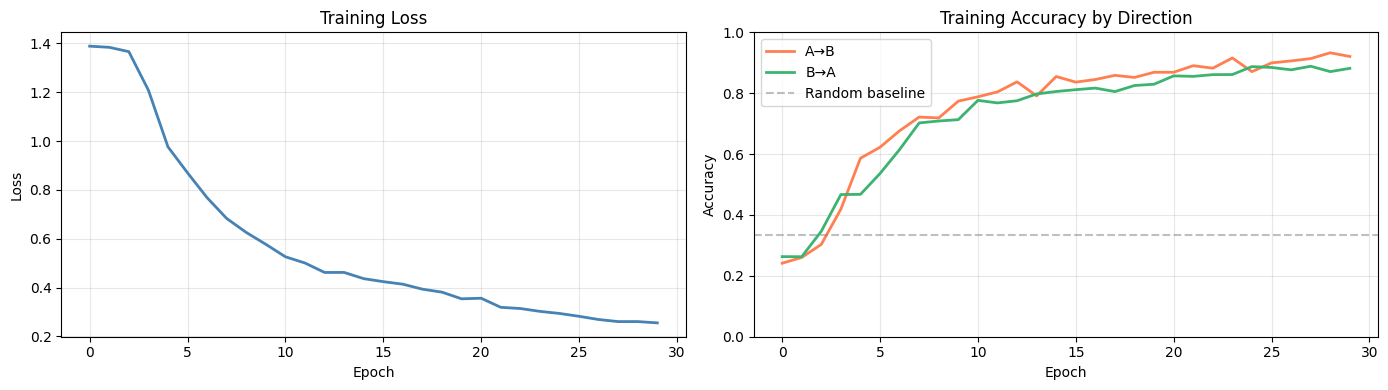

Final results:
  A→B accuracy: 92.1%
  B→A accuracy: 88.2%
  Average: 90.1%


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot loss
axes[0].plot(train_losses, linewidth=2, color='steelblue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Plot accuracy for both directions
axes[1].plot(train_accs_AB, linewidth=2, label='A→B', color='coral')
axes[1].plot(train_accs_BA, linewidth=2, label='B→A', color='mediumseagreen')
axes[1].axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy by Direction')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"Final results:")
print(f"  A→B accuracy: {train_accs_AB[-1]:.1%}")
print(f"  B→A accuracy: {train_accs_BA[-1]:.1%}")
print(f"  Average: {(train_accs_AB[-1] + train_accs_BA[-1])/2:.1%}")

## 8. Post-Training Analysis - Did They Learn?

Let's look at the same examples we saw before training and see how the communication changed!

In [12]:
post_training_samples = collect_samples(game, test_loader, n_samples=10)

for i, s in enumerate(post_training_samples, 1):
    print(f"{i}. {s['dir']}")
    print(f"Target: {s['target']}")
    print("Options:")
    for j, opt in enumerate(s['options']):
        print(f"  {opt}")
    print(f"Message: {s['msg']}")
    print(f"Prediction: {s['pred']}")
    print(f"Correct: {s['correct']}\n")

accuracy = sum(s['correct'] for s in post_training_samples) / len(post_training_samples)
pre_accuracy = sum(s['correct'] for s in samples) / len(samples)
print(f"Post-training accuracy: {accuracy:.1%}")
print(f"Pre-training accuracy: {pre_accuracy:.1%}")
print(f"Improvement: {accuracy - pre_accuracy:.1%}")

1. A→B
Target: [1. 3. 3.]
Options:
  [1. 3. 3.]
  [1. 1. 2.]
  [1. 2. 2.]
  [2. 2. 1.]
Message: [1, 1, 0, 0]
Prediction: 0
Correct: True

2. A→B
Target: [1. 3. 1.]
Options:
  [2. 1. 2.]
  [1. 1. 3.]
  [3. 2. 2.]
  [1. 3. 1.]
Message: [0, 0, 0, 0]
Prediction: 3
Correct: True

3. A→B
Target: [2. 3. 3.]
Options:
  [2. 3. 3.]
  [1. 1. 2.]
  [1. 2. 3.]
  [1. 1. 1.]
Message: [1, 1, 0, 0]
Prediction: 2
Correct: False

4. A→B
Target: [3. 2. 1.]
Options:
  [3. 2. 1.]
  [2. 1. 2.]
  [1. 3. 1.]
  [2. 2. 3.]
Message: [7, 7, 7, 0]
Prediction: 0
Correct: True

5. A→B
Target: [2. 2. 1.]
Options:
  [3. 1. 2.]
  [2. 1. 1.]
  [3. 2. 1.]
  [2. 2. 1.]
Message: [7, 7, 7, 0]
Prediction: 2
Correct: False

6. B→A
Target: [1. 1. 2.]
Options:
  [1. 3. 3.]
  [1. 1. 3.]
  [3. 3. 1.]
  [1. 1. 2.]
Message: [9, 9, 5, 0]
Prediction: 3
Correct: True

7. B→A
Target: [3. 3. 2.]
Options:
  [2. 2. 2.]
  [3. 3. 2.]
  [2. 3. 2.]
  [3. 3. 3.]
Message: [5, 9, 9, 0]
Prediction: 1
Correct: True

8. B→A
Target: [3. 1. 3.]
Option

## 9. Language Analysis - What Does the Language Look Like?

Now let's dig deeper into the emergent language. We'll collect messages from the entire test set and analyze their properties.

### Collect All Messages

In [13]:
def collect_all_messages(game, dataloader, device):
    """Collect all messages from both directions"""
    game.eval()
    game.reset_batch_counter()
    
    data_AB = {'messages': [], 'targets': [], 'correct': []}
    data_BA = {'messages': [], 'targets': [], 'correct': []}
    
    with torch.no_grad():
        for batch in dataloader:
            sender_input, labels, receiver_input = batch
            sender_input = sender_input.to(device)
            labels = labels.to(device)
            receiver_input = receiver_input.to(device)
            
            loss_val, interaction = game(sender_input, labels, receiver_input)
            
            direction = interaction.aux['direction'][0].item()
            message = interaction.message.argmax(dim=-1)  # (batch, max_len+1)
            correct = interaction.aux['acc']
            
            if direction == 0:  # A→B
                data_AB['messages'].extend(message.cpu().numpy())
                data_AB['targets'].extend(sender_input.cpu().numpy())
                data_AB['correct'].extend(correct.cpu().numpy())
            else:  # B→A
                data_BA['messages'].extend(message.cpu().numpy())
                data_BA['targets'].extend(sender_input.cpu().numpy())
                data_BA['correct'].extend(correct.cpu().numpy())
    
    return data_AB, data_BA

data_AB, data_BA = collect_all_messages(game, test_loader, device)

# Final test set accuracy (held-out data, evaluated once after training)
print(f"Final Test Accuracy:")
print(f"  A→B: {np.mean(data_AB['correct']):.1%}")
print(f"  B→A: {np.mean(data_BA['correct']):.1%}")

Final Test Accuracy:
  A→B: 92.2%
  B→A: 85.9%


### Vocabulary Usage - Which Symbols Are Used?

Do agents use all available symbols, or just a subset? Do A and B use different symbols?

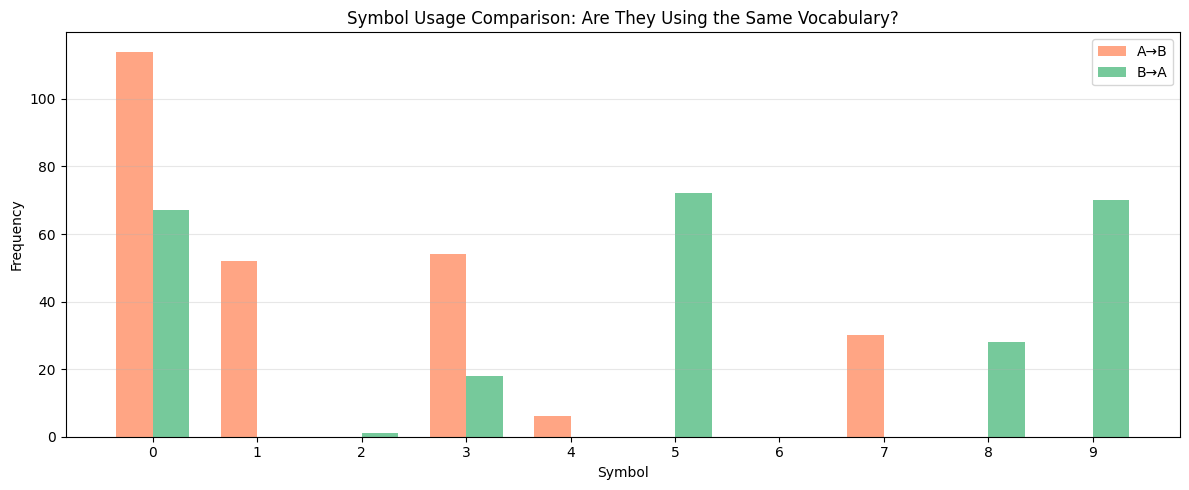

Symbol usage:
  A→B uses 5/10 symbols
  B→A uses 6/10 symbols

Note: Symbol 0 is end-of-sequence (EOS)


In [14]:
def count_symbol_usage(messages, vocab_size, max_len):
    """Count how often each symbol appears in messages"""
    counts = Counter()
    for msg in messages:
        for symbol in msg[:max_len+1]:  # Include EOS position
            counts[symbol] += 1
    return counts

counts_AB = count_symbol_usage(data_AB['messages'], vocab_size, max_len)
counts_BA = count_symbol_usage(data_BA['messages'], vocab_size, max_len)

# Get frequencies for each symbol
symbols = list(range(vocab_size))
freqs_AB = [counts_AB.get(s, 0) for s in symbols]
freqs_BA = [counts_BA.get(s, 0) for s in symbols]

# Create side-by-side bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

x = np.arange(vocab_size)
width = 0.35

ax.bar(x - width/2, freqs_AB, width, label='A→B', color='coral', alpha=0.7)
ax.bar(x + width/2, freqs_BA, width, label='B→A', color='mediumseagreen', alpha=0.7)
ax.set_xlabel('Symbol')
ax.set_ylabel('Frequency')
ax.set_title('Symbol Usage Comparison: Are They Using the Same Vocabulary?')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Symbol usage:")
print(f"  A→B uses {len([c for c in freqs_AB if c > 0])}/{vocab_size} symbols")
print(f"  B→A uses {len([c for c in freqs_BA if c > 0])}/{vocab_size} symbols")
print(f"\nNote: Symbol 0 is end-of-sequence (EOS)")

### Message Length Analysis

Messages can be up to `max_len` symbols long. How long are messages in practice?

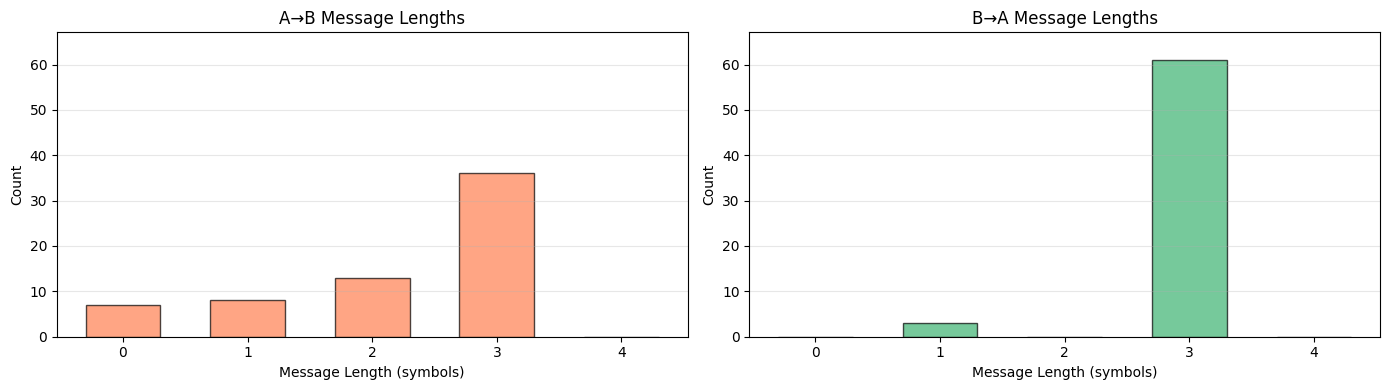

Average message length:
  A→B: 2.22 symbols
  B→A: 2.91 symbols


In [15]:
def get_message_lengths(messages, max_len):
    """Calculate effective message length (stop at first EOS)"""
    lengths = []
    for msg in messages:
        # Find first occurrence of EOS (symbol 0)
        eos_positions = np.where(msg[:max_len+1] == 0)[0]
        if len(eos_positions) > 0:
            length = eos_positions[0]  # Stop at first EOS
        else:
            length = max_len + 1  # No EOS, full length
        lengths.append(length)
    return lengths

lengths_AB = get_message_lengths(data_AB['messages'], max_len)
lengths_BA = get_message_lengths(data_BA['messages'], max_len)

# Count occurrences of each length
from collections import Counter
counts_AB = Counter(lengths_AB)
counts_BA = Counter(lengths_BA)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Possible lengths: 0 to max_len+1
possible_lengths = list(range(max_len + 2))
freqs_AB = [counts_AB.get(length, 0) for length in possible_lengths]
freqs_BA = [counts_BA.get(length, 0) for length in possible_lengths]

# Set common y-axis for comparison
max_count = max(max(freqs_AB), max(freqs_BA))

axes[0].bar(possible_lengths, freqs_AB, color='coral', alpha=0.7, edgecolor='black', width=0.6)
axes[0].set_xlabel('Message Length (symbols)')
axes[0].set_ylabel('Count')
axes[0].set_title('A→B Message Lengths')
axes[0].set_xticks(possible_lengths)
axes[0].set_ylim([0, max_count * 1.1])
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(possible_lengths, freqs_BA, color='mediumseagreen', alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_xlabel('Message Length (symbols)')
axes[1].set_ylabel('Count')
axes[1].set_title('B→A Message Lengths')
axes[1].set_xticks(possible_lengths)
axes[1].set_ylim([0, max_count * 1.1])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Average message length:")
print(f"  A→B: {np.mean(lengths_AB):.2f} symbols")
print(f"  B→A: {np.mean(lengths_BA):.2f} symbols")

### Message Consistency

Do agents produce consistent messages for the same target?

In [16]:
# Find examples where we saw the same target multiple times
def find_repeated_targets(targets, messages, n_examples=3):
    """Find targets that appear multiple times and their messages"""
    from collections import defaultdict
    
    target_to_messages = defaultdict(list)
    for target, message in zip(targets, messages):
        target_tuple = tuple(target)
        target_to_messages[target_tuple].append(message)
    
    # Find targets with multiple occurrences
    repeated = [(t, msgs) for t, msgs in target_to_messages.items() if len(msgs) >= 2]
    return repeated[:n_examples]

repeated_AB = find_repeated_targets(data_AB['targets'], data_AB['messages'])
repeated_BA = find_repeated_targets(data_BA['targets'], data_BA['messages'])

print("Message consistency for repeated targets:\n")
print("A→B direction:")
for i, (target, messages) in enumerate(repeated_AB[:3], 1):
    print(f"  Target {i}: {target}")
    for j, msg in enumerate(messages[:3], 1):
        print(f"    Message {j}: {list(msg[:max_len+1])}")

print("\nB→A direction:")
for i, (target, messages) in enumerate(repeated_BA[:3], 1):
    print(f"  Target {i}: {target}")
    for j, msg in enumerate(messages[:3], 1):
        print(f"    Message {j}: {list(msg[:max_len+1])}")

print("\n→ Messages are mostly consistent for the same target")

Message consistency for repeated targets:

A→B direction:
  Target 1: (1.0, 3.0, 3.0)
    Message 1: [1, 1, 0, 0]
    Message 2: [1, 1, 0, 0]
    Message 3: [1, 1, 0, 0]
  Target 2: (1.0, 3.0, 1.0)
    Message 1: [0, 0, 0, 0]
    Message 2: [0, 0, 0, 0]
    Message 3: [0, 0, 0, 0]
  Target 3: (2.0, 3.0, 3.0)
    Message 1: [1, 1, 0, 0]
    Message 2: [1, 1, 0, 0]
    Message 3: [1, 1, 0, 0]

B→A direction:
  Target 1: (1.0, 1.0, 2.0)
    Message 1: [9, 9, 5, 0]
    Message 2: [9, 9, 5, 0]
  Target 2: (3.0, 3.0, 2.0)
    Message 1: [5, 9, 9, 0]
    Message 2: [5, 9, 9, 0]
    Message 3: [5, 9, 9, 0]
  Target 3: (3.0, 1.0, 3.0)
    Message 1: [5, 0, 5, 0]
    Message 2: [5, 0, 5, 0]
    Message 3: [5, 0, 5, 0]

→ Messages are mostly consistent for the same target


## 10. The Two-Languages Question 🔍

This is the critical question: **Do A and B speak the same language, or two different languages?**

If agents speak the same language, self-play should work just as well as cross-play

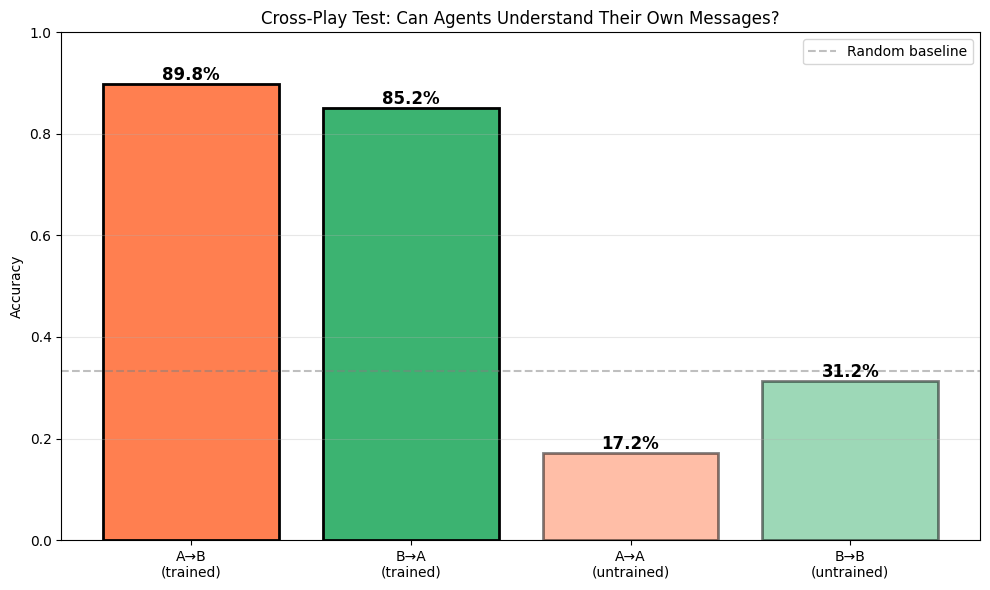


Results:
  A→B (trained): 89.8%
  B→A (trained): 85.2%
  A→A (untrained): 17.2%
  B→B (untrained): 31.2%


In [20]:
# Create self-play games for testing
game_A_to_A = core.SenderReceiverRnnGS(game.sender_A, game.receiver_A, loss)
game_B_to_B = core.SenderReceiverRnnGS(game.sender_B, game.receiver_B, loss)

def test_game_accuracy(game_obj, dataloader, device):
    """Calculate accuracy for a specific game pairing"""
    game_obj.eval()
    accuracies = []
    
    with torch.no_grad():
        for batch in dataloader:
            sender_input, labels, receiver_input = batch
            sender_input = sender_input.to(device)
            labels = labels.to(device)
            receiver_input = receiver_input.to(device)
            
            loss_val, interaction = game_obj(sender_input, labels, receiver_input)
            acc = interaction.aux['acc'].mean().item()
            accuracies.append(acc)
    
    return np.mean(accuracies)

# Test all four pairings
acc_AB = test_game_accuracy(game.game_A_to_B, test_loader, device)
acc_BA = test_game_accuracy(game.game_B_to_A, test_loader, device)
acc_AA = test_game_accuracy(game_A_to_A, test_loader, device)
acc_BB = test_game_accuracy(game_B_to_B, test_loader, device)

# Visualize results
fig, ax = plt.subplots(figsize=(10, 6))

pairings = ['A→B\n(trained)', 'B→A\n(trained)', 'A→A\n(untrained)', 'B→B\n(untrained)']
accuracies = [acc_AB, acc_BA, acc_AA, acc_BB]

# Create bars individually to control alpha
bar1 = ax.bar(0, accuracies[0], color='coral', alpha=1.0, edgecolor='black', linewidth=2)
bar2 = ax.bar(1, accuracies[1], color='mediumseagreen', alpha=1.0, edgecolor='black', linewidth=2)
bar3 = ax.bar(2, accuracies[2], color='coral', alpha=0.5, edgecolor='black', linewidth=2)
bar4 = ax.bar(3, accuracies[3], color='mediumseagreen', alpha=0.5, edgecolor='black', linewidth=2)

ax.axhline(y=1/3, color='gray', linestyle='--', label='Random baseline', alpha=0.5)
ax.set_xticks(range(4))
ax.set_xticklabels(pairings)
ax.set_ylabel('Accuracy')
ax.set_title('Cross-Play Test: Can Agents Understand Their Own Messages?')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, acc in enumerate(accuracies):
    ax.text(i, acc, f'{acc:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nResults:")
print(f"  A→B (trained): {acc_AB:.1%}")
print(f"  B→A (trained): {acc_BA:.1%}")
print(f"  A→A (untrained): {acc_AA:.1%}")
print(f"  B→B (untrained): {acc_BB:.1%}")